# Datathon V - Día 3 - MLOps

A continuación se detallan las actividades y puntos asignados para el reto de MLOps del Datathon V. Cada actividad tiene un puntaje específico y una evaluación que indica si se ha completado correctamente.

| **Actividad**                                                             | **Puntos**      | **Evaluación** |
| ------------------------------------------------------------------------- | --------------- | -------------- |
| **Tareas de Pipeline y MLFlow**                                           | **Total: 7**    |                |
| Crear un Pipeline de Scikit-Learn                                         | 0.5             | ✅            |
| Lanzar un servidor MLflow local                                           | 0.5             | ✅            |
| Entrenar y evaluar el modelo dentro de una ejecución de MLflow            | 0.5             | ✅            |
| Registrar el modelo y las métricas con MLflow                             | 0.5             | ✅            |
| Registrar el modelo en MLflow                                             | 0.5             | ✅            |
| Desplegar el modelo como una API REST (con Docker)                        | 2.0             | ✅            |
| Hacer predicciones usando la API REST                                     | 2.0             | ✅            |
| Subir las predicciones a la base de datos                                 | 0.5             | ✅            |
| **Código y Documentación**                                                | **Total: 1**    |               |
| Legibilidad del código                                                    | 0.5             | ✅            |
| Documentación en el notebook (títulos, subtítulos, texto)                 | 0.5             | ✅            |
| **Repositorio GIT**                                                       | **Total: 1**    |                |
| Incluir un archivo README.md completo                                     | 0.5             | ✅            |
| Uso de ramas para el desarrollo                                           | 0.5             | ✅            |
| **Puntos Extra (Bonus)**                                                  | **1 + Bonus**   |                |
| Explorar nuevas técnicas, modelos o productos                             | *Bonus*         | ✅              |
| Crear un pequeño artículo y promocionarlo                                 | *Bonus*         | ✅              |
| Cualquier otra iniciativa personal que mejore el proyecto                 | *Bonus*         | ✅              |
| **Evaluaciones Negativas**                                                | **Total: -9.0** |                  |
| Subir datos al repositorio                                                | -3.0            | ❌              |
| Subir contraseñas o información sensible                                  | -3.0            | ❌              |
| Subir archivos generados por MLflow (ej. `mlruns`)                        | -1.0            | ❌              |
| Faltan archivos estándar de Python (ej. `requirements.txt`, `.gitignore`) | -1.0            | ❌              |
| Un archivo README.md con mala presentación                                | -1.0            | ❌              |


**Notes**:
- Puntos Totales: 10 (sin contar los bonus ni los aspectos negativos).
- Los puntos extra pueden mejorar la puntuación, pero no permiten superar el máximo de 10 puntos.
- Las malas prácticas restan puntos.

## 1. Introducción

Lo primero: ¡Enhorabuena! 🎉 Si has llegado hasta aquí, quiere decir que te estas tomando tu formacion muy en serio. 

En este reto de MLOps, vamos a poner en práctica todo lo aprendido hasta ahora. El objetivo es desplegar un modelo registrado en MLFlow y hacer predicciones con él. Finalmente, subiremos los resultados a una base de datos para que puedan ser consultados durante la ultima fase del Datathon. Repasaremos el preprocesamiento de los datos y el entrenamiento del modelo dandole una vuelta: aprenderemos también a simplificar el procesamiento de los datos haciendo uso de un Pipeline de Scikit-Learn.

¿Listo/a? ¡Vamos a ello! 🚀

## 2. Obtención de los datos

En esta sección, vamos a cargar los datos desde la base de datos y vamos a convertir la serie temporal de ventas en un ejercicio Supervisado.

### 2.1 Cargar los datos desde la base de datos

Nos conectamos a la base de datos y ejecutamos una query para obtener los datos de ventas. Utilizamos la librería `pandas` para manejar los datos y `sqlalchemy` para conectarnos a la base de datos.

In [1]:
## importar y crear conexion a base de datos
import pandas as pd
import sqlalchemy as sa


class DatabaseConnection:

    def __init__(
        self,
        username: str,
        password: str,
        database: str = "sandbox",
        host: str = "database-1.cjyy8w6ya3fr.eu-north-1.rds.amazonaws.com",
        port: int = 3306,
        dialect: str = "mysql",
        driver: str = "pymysql",
    ) -> None:
        """Creates a connection to a database

        Args:
            username (str): username
            password (str): password
            dialect (str, optional): dialect. Defaults to "mysql".
            driver (str, optional): driver. Defaults to "pymysql".
            host (str, optional): host. Defaults to "database-1.crek3tiqyj7r.eu-west-3.rds.amazonaws.com".
            port (int, optional): port. Defaults to 3306.
            database (str, optional): database. Defaults to "sandbox".
        """
        connection_string = f"{dialect}+{driver}://{username}:{password}@{host}:{port}/{database}"
        self.engine = sa.create_engine(connection_string)

    def insert_dataframe(self, df: pd.DataFrame, table_name: str) -> None:
        """Inserts a dataframe into a table
        
        Args:
            df (pd.DataFrame): dataframe to insert
            table_name (str): table name
        """
        df.to_sql(table_name, self.engine, if_exists="replace", index=False)

    def query_to_df(self, query: str) -> pd.DataFrame:
        """Retrieves a dataframe from a query.

        Args:
            query (str): query to perform.

        Returns:
            pd.DataFrame: daframe with the results of the query.
        """
        with self.engine.connect() as conn:
            df = pd.read_sql_query(query, conn)
            return df

    def check_connection(self) -> bool:
        """Checks if the connection is working

        Returns:
            bool: True if the connection is working, False otherwise
        """
        try:
            self.engine.connect()
        except Exception as e:
            print(e)
            return False

Seteamos las Variables de Configuracion

Conectamos con la base de datos

Realizamos la consulta SQL para obtener los datos de ventas

In [3]:
## realizar consulta
query = """
    SELECT familia,
        articulo,
        fechaVenta AS fecha_venta,
        festivo,
        precio,
        cantidad,
        importe,
        orden_articulo_familia

    FROM sandbox.EHR_ventas_diarias_estudio
"""


df = database.query_to_df(query)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10322 entries, 0 to 10321
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   familia                 10322 non-null  object 
 1   articulo                10322 non-null  object 
 2   fecha_venta             10322 non-null  object 
 3   festivo                 809 non-null    object 
 4   precio                  10322 non-null  float64
 5   cantidad                10322 non-null  float64
 6   importe                 10322 non-null  float64
 7   orden_articulo_familia  10322 non-null  int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 645.3+ KB


In [4]:
## visualizar resultados
df.head()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia
0,BOLLERIA,3880,2021-05-01,None,2.591,285.000,738.434998,3
1,BOLLERIA,3960,2021-05-01,None,2.318,402.000,931.835995,1
2,BOLLERIA,5803,2021-05-01,None,2.727,237.000,646.298981,5
3,BOLLERIA,6286,2021-05-01,None,3.136,165.000,517.440006,4
4,BOLLERIA,6425,2021-05-01,None,31.364,31.725,995.022083,2


Convertimos las fechas a formato datetime y los artículos a tipo int

In [5]:
## transformar tipos de datos
df["fecha_venta"] = pd.to_datetime(df["fecha_venta"])
df["articulo"] = df["articulo"].astype(int)

### 2.2 Filtramos para un solo producto

Hemos seleccionado el PRODUCT_ID 3960, pero podemos seleccionar cualquier otro producto.

In [6]:
# Filtrar por producto
PRODUCT_ID = 5404

item_mask = df["articulo"] == PRODUCT_ID
item_df = df[item_mask].copy()

Organizamos los datos por fecha y reiniciamos el índice

In [7]:
## ordenar resultados
item_df.sort_values("fecha_venta", inplace=True)
item_df.reset_index(inplace=True, drop=True)
item_df.head()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia
0,PASTELERIA,5404,2021-05-01,None,39.544998,21.90,866.037010,1
1,PASTELERIA,5404,2021-05-02,Día de la Madre,39.544998,46.71,1847.148033,1
2,PASTELERIA,5404,2021-05-03,Día de la Cruz,39.544998,10.50,415.223007,1
3,PASTELERIA,5404,2021-05-04,None,39.544998,18.00,711.810013,1
4,PASTELERIA,5404,2021-05-05,None,39.544998,2.70,106.772003,1


### 2.3 Convertimos la serie a formato supervisado

Para poder predecir las ventas, necesitamos transformar los datos en un problema supervisado. Para ello vamos a:

- 👉 Obtener la `cantidad` contabilizada los días anteriores y añadirlos al día presente (shift).
- 👉 Obtener la `cantidad` contabilizada las semanas anteriores y añadirlos al día presente (shift).

👇 Para facilitar el proceso hemos diseñado una función que nos permite transformar la serie a formato supervisado. Esta función recibe como parámetros el dataframe, el número de días y semanas a considerar.

In [8]:
## crear funciones de utilidad
def series_to_supervised(
    df: pd.DataFrame,
    target_colum: str = "cantidad",
    daily_lag: int = 1,
    weekly_lag: int = 1,
) -> pd.DataFrame:
    """
    Converts a time series dataset into a supervised learning dataset.
    
    Args:
        data: Sequence of observations as a numpy array or DataFrame.
        daily_lag: Number of daily lag observations to include as inputs (X).
        weekly_lag: Number of weekly lag observations to include as inputs (X).
    
    Returns:
        Pandas DataFrame suitable for supervised learning.
    """
    final_df = df.copy()
    target_feature = final_df[target_colum]

    def create_shifted_feature(lag: int, frequency: int, freq_label: str):
        """Create lagged features for the given lag and frequency."""
        shifted_feature = target_feature.shift(lag * frequency)
        feature_name = f"{target_feature.name} (t-{lag} {freq_label})"
        final_df[feature_name] = shifted_feature

    # Add weekly lagged features
    for lag in range(weekly_lag, 0, -1):
        create_shifted_feature(lag, 7, "weeks")

    # Add daily lagged features
    for lag in range(daily_lag, 0, -1):
        create_shifted_feature(lag, 1, "days")

    return final_df

In [9]:
## añadir campos de cantidad de dias posteriores
item_df = series_to_supervised(item_df, daily_lag=6, weekly_lag=4)
item_df.head()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,cantidad (t-4 weeks),cantidad (t-3 weeks),cantidad (t-2 weeks),cantidad (t-1 weeks),cantidad (t-6 days),cantidad (t-5 days),cantidad (t-4 days),cantidad (t-3 days),cantidad (t-2 days),cantidad (t-1 days)
0,PASTELERIA,5404,2021-05-01,None,39.544998,21.90,866.037010,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PASTELERIA,5404,2021-05-02,Día de la Madre,39.544998,46.71,1847.148033,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.90
2,PASTELERIA,5404,2021-05-03,Día de la Cruz,39.544998,10.50,415.223007,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.90,46.71
3,PASTELERIA,5404,2021-05-04,None,39.544998,18.00,711.810013,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.90,46.71,10.50
4,PASTELERIA,5404,2021-05-05,None,39.544998,2.70,106.772003,1,NaN,NaN,NaN,NaN,NaN,NaN,21.9,46.71,10.50,18.00


## 3. Preprocesamiento de los datos

Hasta ahora en clase hemos visto como podemos modificar los datos de entrada para adaptarlos a los modelos. En este caso vamos a ir un paso más allá y vamos a **crear un Flujo de Transformacion de Datos (Data Pipeline)** que nos permita transformar los datos de entrada en un formato adecuado para el modelo.

Cuales son las transformaciones que vamos a realizar?

- 👉 **Extraer info de la fecha de venta**: el día, el mes, el año, el día de la semana y si es fin de semana o no.
- 👉 **Indicar si el día es festivo o no.**
- 👉 **Agregar informacion meteorológica**: temperatura, humedad, velocidad del viento y precipitaciones...


💡El uso de funciones nos permite reutilizar el codigo tantas veces como queramos.

### 3.1 Extraemos info de la fecha de venta

A traves de la fecha de venta vamos a crear las siguientes columnas:

- 👉 El día de la semana ( `dayofweek`)
- 👉 El día del mes (`day`)
- 👉 El mes (`month`)
- 👉 El año (`year`)
- 👉 Si es fin de semana o no (`weekend`)

In [10]:
## agregar columnas de fecha
def add_date_columns(df: pd.DataFrame, date_column: str = "fecha_venta") -> pd.DataFrame:
    df["day"] = df[date_column].dt.day
    df["month"] = df[date_column].dt.month
    df["year"] = df[date_column].dt.year
    df["dayofweek"] = df[date_column].dt.dayofweek + 1
    df["isWeekend"] = df["dayofweek"] >= 6
    return df

item_df_tmp = item_df.copy()
add_date_columns(item_df_tmp).head()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,cantidad (t-4 weeks),cantidad (t-3 weeks),...,cantidad (t-5 days),cantidad (t-4 days),cantidad (t-3 days),cantidad (t-2 days),cantidad (t-1 days),day,month,year,dayofweek,isWeekend
0,PASTELERIA,5404,2021-05-01,None,39.544998,21.90,866.037010,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,5,2021,6,True
1,PASTELERIA,5404,2021-05-02,Día de la Madre,39.544998,46.71,1847.148033,1,NaN,NaN,...,NaN,NaN,NaN,NaN,21.90,2,5,2021,7,True
2,PASTELERIA,5404,2021-05-03,Día de la Cruz,39.544998,10.50,415.223007,1,NaN,NaN,...,NaN,NaN,NaN,21.90,46.71,3,5,2021,1,False
3,PASTELERIA,5404,2021-05-04,None,39.544998,18.00,711.810013,1,NaN,NaN,...,NaN,NaN,21.90,46.71,10.50,4,5,2021,2,False
4,PASTELERIA,5404,2021-05-05,None,39.544998,2.70,106.772003,1,NaN,NaN,...,NaN,21.9,46.71,10.50,18.00,5,5,2021,3,False


### 3.2 Indicamos si es festivo o no

Para ello sustituimos los valores de la columna `isHoliday` por `True` si el día es festivo y `False` si no lo es. A continuación, eliminamos la columna `festivo`, de tipo `str`, ya que no la vamos a necesitar.

In [11]:
## agregar columna de festivos
def add_holiday_column(df: pd.DataFrame, holiday_column_name: str = "festivo") -> pd.DataFrame:
    df["isHoliday"]  = ~df[holiday_column_name].isna()
    df.drop(columns=["festivo"], inplace=True)
    return df

item_df_tmp = item_df.copy()
add_holiday_column(item_df_tmp).head()

,familia,articulo,fecha_venta,precio,cantidad,importe,orden_articulo_familia,cantidad (t-4 weeks),cantidad (t-3 weeks),cantidad (t-2 weeks),cantidad (t-1 weeks),cantidad (t-6 days),cantidad (t-5 days),cantidad (t-4 days),cantidad (t-3 days),cantidad (t-2 days),cantidad (t-1 days),isHoliday
0,PASTELERIA,5404,2021-05-01,39.544998,21.90,866.037010,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,PASTELERIA,5404,2021-05-02,39.544998,46.71,1847.148033,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.90,True
2,PASTELERIA,5404,2021-05-03,39.544998,10.50,415.223007,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.90,46.71,True
3,PASTELERIA,5404,2021-05-04,39.544998,18.00,711.810013,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.90,46.71,10.50,False
4,PASTELERIA,5404,2021-05-05,39.544998,2.70,106.772003,1,NaN,NaN,NaN,NaN,NaN,NaN,21.9,46.71,10.50,18.00,False


### 3.3 Agregamos la información meteorológica

Utilizamos la API de meteostat para obtener los datos meteorológicos.

- 👉 Añadir las condiciones meteorológicas para las fechas en el dataframe
- 👉 Añadir una columna `rain` que indique si ese dia hubo o no lluvia (verdadero/falso).

In [12]:
from datetime import datetime
from meteostat import Point, Daily
import numpy as np


def get_weather_df(start: datetime, end: datetime, location: tuple[int, int]) -> pd.DataFrame:
    lat, lon = location
    point = Point(lat, lon)
    return Daily(point, start, end).fetch().fillna(0).reset_index()

def merge_dfs_by_column(df1: pd.DataFrame, df2: pd.DataFrame, col_1_name: str, col_2_name: str) -> pd.DataFrame:
    merged_df = df1.reset_index().merge(df2, left_on=col_1_name, right_on=col_2_name, how="inner").set_index("index")
    merged_df.index.name = None
    return merged_df

def add_rain_column(df: pd.DataFrame, precipitation_column_name: str = "prcp") -> pd.DataFrame:
    rain_condition = df[precipitation_column_name] > 0
    df["isRaining"] = np.where(rain_condition, True, False)
    return df

def add_weather_columns(
    df: pd.DataFrame,
    location: tuple[int, int],
    date_column_name: str = "fecha_venta",
) -> pd.DataFrame:
    start = df[date_column_name].min()
    end = df[date_column_name].max()
    weather_df = get_weather_df(start, end, location)
    weather_df = add_rain_column(weather_df)
    weather_df = merge_dfs_by_column(df, weather_df, date_column_name, "time")
    return weather_df

In [ ]:
## 
from datetime import datetime
from meteostat import Point, Daily
import numpy as np

def get_weather_df(start: datetime, end: datetime, location: tuple[int, int]) -> pd.DataFrame:
	lat, lon = location
	point = Point(lat, lon)
	return Daily(point, start, end).fetch().fillna(0).reset_index()

def merge_dfs_by_column(df1: pd.DataFrame, df2: pd.DataFrame, col_1_name: str, col_2_name: str) -> pd.DataFrame:
	merged_df = df1.reset_index().merge(df2, left_on=col_1_name, right_on=col_2_name, how="inner").set_index("index")
	merged_df.index.name = None
	return merged_df

def add_rain_column(df: pd.DataFrame, precipitation_column_name: str = "prcp") -> pd.DataFrame:
	rain_condition = df[precipitation_column_name] > 0
	df["isRaining"] = np.where(rain_condition, True, False)
	return df

def add_weather_columns(
	df: pd.DataFrame,
	location: tuple[int, int],
	date_column_name: str = "fecha_venta",
) -> pd.DataFrame:
	start = df[date_column_name].min()
	end = df[date_column_name].max()
	weather_df = get_weather_df(start, end, location)
	weather_df = add_rain_column(weather_df)
	weather_df = merge_dfs_by_column(df, weather_df, date_column_name, "time")
	return weather_df

# 👈 Define your location (latitude, longitude)
item_df_tmp = item_df.copy()
add_weather_columns(item_df_tmp, LOCATION).head()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,cantidad (t-4 weeks),cantidad (t-3 weeks),...,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,isRaining
0,PASTELERIA,5404,2021-05-01,None,39.544998,21.90,866.037010,1,NaN,NaN,...,11.9,22.8,0.0,0.0,0.0,14.2,0.0,1014.0,0.0,False
1,PASTELERIA,5404,2021-05-02,Día de la Madre,39.544998,46.71,1847.148033,1,NaN,NaN,...,10.8,23.2,0.0,0.0,0.0,15.7,0.0,1015.9,0.0,False
2,PASTELERIA,5404,2021-05-03,Día de la Cruz,39.544998,10.50,415.223007,1,NaN,NaN,...,12.7,20.1,6.5,0.0,0.0,9.7,0.0,1017.7,0.0,True
3,PASTELERIA,5404,2021-05-04,None,39.544998,18.00,711.810013,1,NaN,NaN,...,12.0,20.9,0.0,0.0,0.0,12.1,0.0,1018.0,0.0,False
4,PASTELERIA,5404,2021-05-05,None,39.544998,2.70,106.772003,1,NaN,NaN,...,12.3,21.7,0.0,0.0,0.0,13.8,0.0,1016.5,0.0,False


## 4. Creación del Pipeline 

Sklearn nos permite crear un Pipeline de Transformación de Datos que nos permite aplicar las transformaciones de manera secuencial. Al final del pipeline incluiríamos el modelo de Machine Learning que queremos utilizar. De esta manera, podemos aplicar las transformaciones de manera automática cada vez que entrenamos el modelo. Aumentamos la reusabilidad del código y la legibilidad del mismo. Los pasos del pipeline son:

1. Aplicar las transformaciones de los datos de entrada.
2. Normalizar los datos de entrada utilizando OneHotEncoder y MinMaxScaler.
3. Rellenar los valores nulos calculando la media de cada columna.
4. Incluir un modelo de Machine Learning al final del pipeline.
5. Normalizar la variable objetivo (target) utilizando MinMaxScaler.

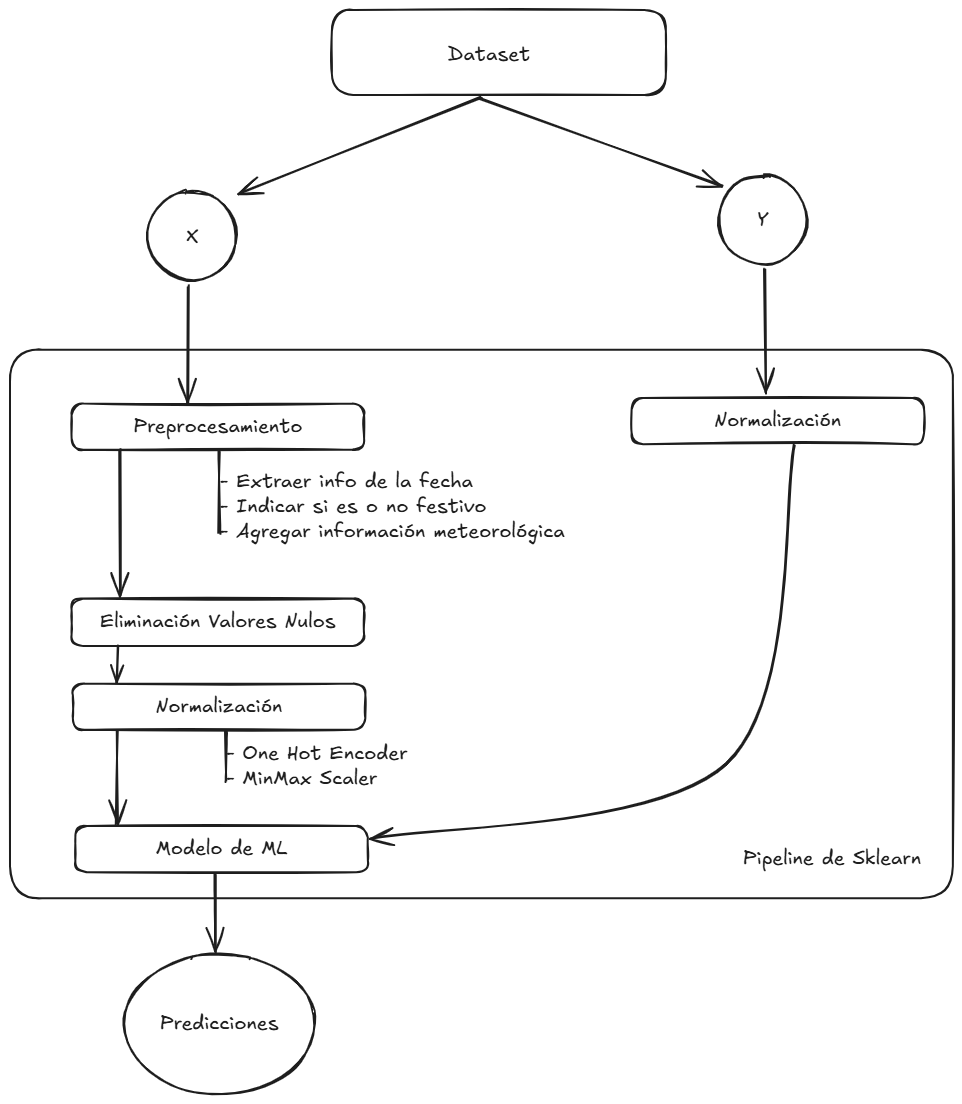

### 4.1 Paso 1: Preprocesamiento de los datos de entrada

Agregamos todas las transformaciones que hemos desarrollado en la sección anterior en un Pipeline de Transformación de Datos.

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin


class PreprocessTransformer(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def __init__(self, location: tuple[int, int]):
        self.location = location

    def fit(self, X: pd.DataFrame, y: pd.Series | None = None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()  # avoid modifying incoming data
        X = add_date_columns(X)
        X = add_holiday_column(X)
        X = add_weather_columns(X, location=self.location)
        return X

In [15]:
item_df.head()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,cantidad (t-4 weeks),cantidad (t-3 weeks),cantidad (t-2 weeks),cantidad (t-1 weeks),cantidad (t-6 days),cantidad (t-5 days),cantidad (t-4 days),cantidad (t-3 days),cantidad (t-2 days),cantidad (t-1 days)
0,PASTELERIA,5404,2021-05-01,None,39.544998,21.90,866.037010,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PASTELERIA,5404,2021-05-02,Día de la Madre,39.544998,46.71,1847.148033,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.90
2,PASTELERIA,5404,2021-05-03,Día de la Cruz,39.544998,10.50,415.223007,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.90,46.71
3,PASTELERIA,5404,2021-05-04,None,39.544998,18.00,711.810013,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.90,46.71,10.50
4,PASTELERIA,5404,2021-05-05,None,39.544998,2.70,106.772003,1,NaN,NaN,NaN,NaN,NaN,NaN,21.9,46.71,10.50,18.00


In [16]:
## Preprocesar datos
preprocessor = PreprocessTransformer(location=LOCATION)
preprocessed_df = preprocessor.transform(item_df)
preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 636 entries, 0 to 635
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   familia                 636 non-null    object        
 1   articulo                636 non-null    int64         
 2   fecha_venta             636 non-null    datetime64[ns]
 3   precio                  636 non-null    float64       
 4   cantidad                636 non-null    float64       
 5   importe                 636 non-null    float64       
 6   orden_articulo_familia  636 non-null    int64         
 7   cantidad (t-4 weeks)    608 non-null    float64       
 8   cantidad (t-3 weeks)    615 non-null    float64       
 9   cantidad (t-2 weeks)    622 non-null    float64       
 10  cantidad (t-1 weeks)    629 non-null    float64       
 11  cantidad (t-6 days)     630 non-null    float64       
 12  cantidad (t-5 days)     631 non-null    float64       


### 4.2 Paso 2: Eliminar los valores nulos

En este paso simplemente rellenamos los valores nulos calculando la media de cada columna.

In [17]:
## rellenar valores nulos con la media
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector

numerical_features = make_column_selector(dtype_include=[np.float64])


nans_remover = SimpleImputer(strategy="mean")

remove_nans_transformer = ColumnTransformer(
    transformers=[
        ("RemoveNans", nans_remover, numerical_features),
    ],
)


### 4.3 Paso 3: Normalización de los datos de entrada

Usamos `OneHotEncoder` para las variables categoricas y `MinMaxScaler`. para las variables numéricas.

In [18]:
## normalizar datos de entrada 
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector


categorical_features = make_column_selector(dtype_include=[object, np.int32])
numerical_features = make_column_selector(dtype_include=[np.float64])

ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
minmax_scaler = MinMaxScaler(feature_range=(0, 1))

encoders_transformer = ColumnTransformer(
    transformers=[
        ("OneHotEncoder", ohe_encoder, categorical_features),
        ("MinMaxScaler", minmax_scaler, numerical_features),
    ],
)


### 4.4 Incluimos el modelo de Machine Learning

Como nos encontramos en un problema de regresión, vamos a utilizar un modelo de regresión. En este caso, vamos a utilizar el modelo `LinearRegression` de Scikit-Learn.

In [19]:
## usar modelo de regresion
from sklearn.linear_model import LinearRegression


model = LinearRegression()
model

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### 4.5 Creamos el pipeline para las variables de entrada

Agregamos los pasos anteriores al pipeline de transformación de datos de forma secuencial. El pipeline se encargará de aplicar las transformaciones a los datos de entrada y de entrenar el modelo.

In [20]:
## agregar pasos anteriores al pipeline
from sklearn.pipeline import Pipeline


input_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("nan_remover", remove_nans_transformer),
        ("data_encoding", encoders_transformer),
        ("model", model),
    ]
)

input_pipeline.set_output(transform="pandas")

,steps,"[('preprocessor', ...), ('nan_remover', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,location,"(36.721477644071705, ...)"
,transformers,"[('RemoveNans', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


### 4.6 Paso 5: Normalizamos la variable objetivo

En ultimo paso, usamos el mismo `OneHotEncoder` utilizado para los datos de entrada para codificar la variable objetivo (target), pero sin ajustarlo nuevamente. Esto asegura que la variable objetivo esté en el mismo formato que los datos de entrada, facilitando así la predicción y evaluación del modelo.

In [21]:
## codificar la variable objetivo para igualar en formato a los datos de entrada
from sklearn.compose import TransformedTargetRegressor


target_feature_scaler = MinMaxScaler(feature_range=(0,1))
final_pipeline = TransformedTargetRegressor(
    regressor=input_pipeline,
    transformer=target_feature_scaler,
)
final_pipeline

,regressor,Pipeline(step...egression())])
,transformer,MinMaxScaler()
,func,None
,inverse_func,None
,check_inverse,True
,location,"(36.721477644071705, ...)"
,transformers,"[('RemoveNans', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None


## 5. Entrenamos el modelo

Utilizamos el pipeline creado anteriormente para entrenar el modelo. Marcamos el horizonte de tiempo del conjunto de test a 30 días. Esto significa que el modelo se evaluará con los datos de los últimos 30 días y se entrenará con los datos previos a dicho horizonte. Elegimos un solo producto para simplificar el proceso de entrenamiento y evaluación del modelo.

In [22]:
## realizar consulta del producto
PRODUCT_ID = 5404

item_mask = df["articulo"] == PRODUCT_ID
item_df = df[item_mask].copy()
item_df.head()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia
7295,PASTELERIA,5404,2021-05-01,None,39.544998,21.90,866.037010,1
7300,PASTELERIA,5404,2021-05-02,Día de la Madre,39.544998,46.71,1847.148033,1
7305,PASTELERIA,5404,2021-05-03,Día de la Cruz,39.544998,10.50,415.223007,1
7309,PASTELERIA,5404,2021-05-04,None,39.544998,18.00,711.810013,1
7312,PASTELERIA,5404,2021-05-05,None,39.544998,2.70,106.772003,1


Guardamos la familia a la que pertenece el producto para guardarlo como tag en MLFlow

In [23]:
product_family = item_df["familia"].iloc[0]
product_family

'PASTELERIA'

### 5.1 Pequeña limpieza previa de los datos

Eliminamos las columnas que no vamos a utilizar

In [24]:
## eliminar columnas no utilizables
item_df.drop(columns=['importe', 'articulo', 'familia', 'orden_articulo_familia'], inplace=True)
item_df.head()

,fecha_venta,festivo,precio,cantidad
7295,2021-05-01,None,39.544998,21.90
7300,2021-05-02,Día de la Madre,39.544998,46.71
7305,2021-05-03,Día de la Cruz,39.544998,10.50
7309,2021-05-04,None,39.544998,18.00
7312,2021-05-05,None,39.544998,2.70


Reorganizamos el dataframe para que el orden de las fechas sea ascendente

In [25]:
## ordenar resultados
item_df.sort_values("fecha_venta", inplace=True)
item_df.reset_index(inplace=True, drop=True)
item_df.head()

,fecha_venta,festivo,precio,cantidad
0,2021-05-01,None,39.544998,21.90
1,2021-05-02,Día de la Madre,39.544998,46.71
2,2021-05-03,Día de la Cruz,39.544998,10.50
3,2021-05-04,None,39.544998,18.00
4,2021-05-05,None,39.544998,2.70


Convertimos la serie a formato supervisado

In [26]:
## convertir a formato supervisado
item_df = series_to_supervised(item_df, daily_lag=6, weekly_lag=4)
item_df.head()

,fecha_venta,festivo,precio,cantidad,cantidad (t-4 weeks),cantidad (t-3 weeks),cantidad (t-2 weeks),cantidad (t-1 weeks),cantidad (t-6 days),cantidad (t-5 days),cantidad (t-4 days),cantidad (t-3 days),cantidad (t-2 days),cantidad (t-1 days)
0,2021-05-01,None,39.544998,21.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-05-02,Día de la Madre,39.544998,46.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.90
2,2021-05-03,Día de la Cruz,39.544998,10.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.90,46.71
3,2021-05-04,None,39.544998,18.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.90,46.71,10.50
4,2021-05-05,None,39.544998,2.70,NaN,NaN,NaN,NaN,NaN,NaN,21.9,46.71,10.50,18.00


### 5.2 Dividimos en conjuntos de entrenamiento y test

In [27]:
## dividir en train y test
horizont = datetime(2023,4,19)


df_train = item_df.loc[item_df["fecha_venta"]<horizont]
df_test = item_df.loc[item_df["fecha_venta"]>=horizont]


X_train = df_train.drop(columns=["cantidad"])
y_train = df_train["cantidad"]
X_test = df_test.drop(columns=["cantidad"])
y_test = df_test["cantidad"]

### 5.3 Iniciar el servidor de MLFlow

- 👉 Lanzar un servidor MLFlow local
- 👉 Conectarse al servidor MLFlow local
- 👉 Establecer el experimento deseado
- 👉 Habilitar el autologging de MLFlow para sklearn

In [28]:
## Configurar MLFlow
%pip install mlflow

import mlflow

# Connect to MLFlow server hosted locally
MLFLOW_EXPERIMENT_NAME = "Datathon V"
MLFLOW_TRACKING_URI = "http://localhost:5000"


mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
mlflow.sklearn.autolog()

Note: you may need to restart the kernel to use updated packages.


### 5.4 Entrenamos y evaluamos el modelo

La siguiente sección consiste en entrenar y evaluar el modelo. Veremos como al utilizar el pipeline se simplifica el proceso de entrenamiento y evaluación del modelo. 

💡 El autolog registrará automáticamente las métricas y el modelo

In [29]:
## entrena y evalua modelo
from sklearn import metrics

mlflow.end_run()  # End any previous run if active

with mlflow.start_run() as run:

    mlflow.set_tag("product_family", product_family)
    mlflow.set_tag("product_id", PRODUCT_ID)

    final_pipeline.fit(X_train, y_train)
    y_pred = final_pipeline.predict(X_test)

    mae = metrics.mean_absolute_error(y_test, y_pred)
    mlflow.log_metric('mae', mae)

🏃 View run youthful-shad-581 at: http://localhost:5000/#/experiments/593696523720765029/runs/e93ed91f5cee4a4f8a869aeab0003572
🧪 View experiment at: http://localhost:5000/#/experiments/593696523720765029


### 5.5 Creamos graficos de resultados

Mostramos la diferencia entre las ventas reales y las predicciones

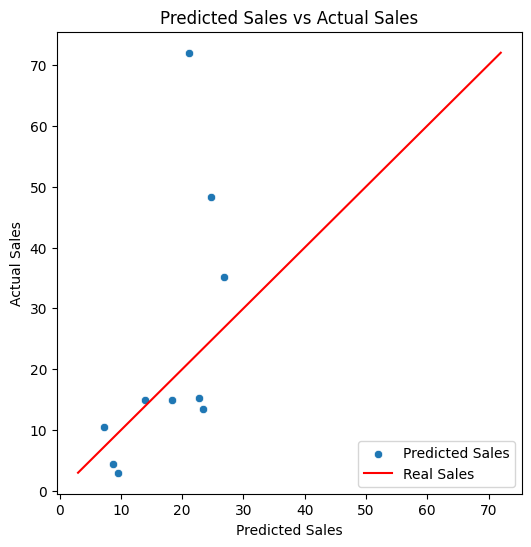

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Predicted Sales")
ax.set_ylabel("Actual Sales")

sns.scatterplot(x=y_pred, y=y_test, ax=ax, label="Predicted Sales")
sns.lineplot(x=y_test, y=y_test, color="red", ax=ax, label="Real Sales")

# Save to MLFlow last run
fig_path = 'predictions_vs_ground_truth.png'
plt.savefig(fig_path)
mlflow.log_artifact(fig_path)

Mostramos la diferencia entre las ventas reales y las predicciones a lo largo del tiempo

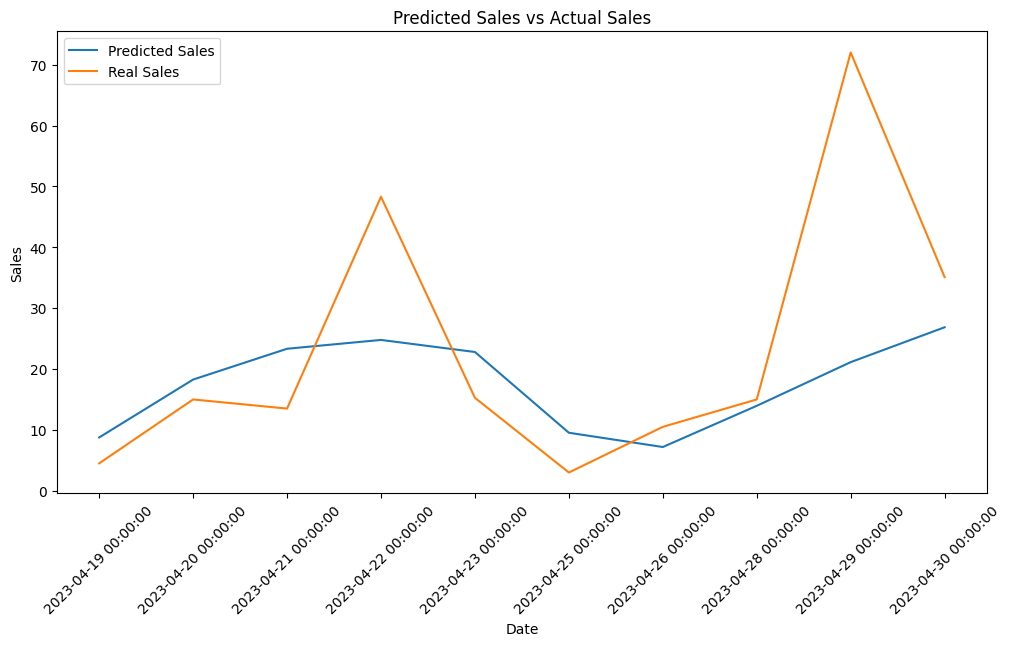

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.set_xticklabels(df_test["fecha_venta"], rotation=45)

dates = df_test["fecha_venta"].astype(str)
sns.lineplot(x=dates, y=y_pred, label="Predicted Sales")
sns.lineplot(x=dates, y=y_test, label="Real Sales")

# Save to MLFlow last run
fig_path = 'predictions_vs_ground_truth_timeline.png'
plt.savefig(fig_path)
mlflow.log_artifact(fig_path)

## 6. Productivización del modelo

👇 Utiliza tus conocimientos de MLOps para desplegar un modelo registrado en MLFlow. Si todo ha ido correctamente deberias ver unos logs similares a estos:

```bash
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     Started parent process [15]
INFO:     Started server process [20]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
```

## 7. Haz peticiones al modelo

Una vez has desplegado el modelo, puedes hacer peticiones al mismo. Aplica los conocimientos de comunicación entre servicios que hemos visto en clase para hacer una petición al modelo. Enviale el conjunto de test y obtendrás las predicciones del modelo.

- ⚠️ Importante: el campo `fecha_venta` debes convertirlo a `string` previamente para que pueda ser enviado al modelo.
- ⚠️ Importante: guarda las predicciones en una variable `predictions` para que puedas utilizarlas posteriormente.

In [ ]:
# 👇 add your code here



## 8. Sube tus resultados a la base de datos

Sube las predicciones devueltas por el modelo desplegado a la base de datos. De esta forma podras utilizarlos en Tableau, PowerBI, etc. Primero creamos el dataframe que subiremos a la base de datos. Este dataframe contendrá las siguientes columnas:

| **Columna**      | **Descripción**                                  |
|------------------|--------------------------------------------------|
| `fecha`          | Fecha de la predicción                           |
| `cantidad`       | Ventas predichas por el modelo                   |
| `articulo`       | ID del producto                                  |
| `familia`        | Familia del producto                             |


In [32]:
df_test

,fecha_venta,festivo,precio,cantidad,cantidad (t-4 weeks),cantidad (t-3 weeks),cantidad (t-2 weeks),cantidad (t-1 weeks),cantidad (t-6 days),cantidad (t-5 days),cantidad (t-4 days),cantidad (t-3 days),cantidad (t-2 days),cantidad (t-1 days)
626,2023-04-19,None,43.5,4.500000,37.80,3.0,3.000000,14.400001,13.500000,21.000000,52.199999,24.45,17.61,3.000000
627,2023-04-20,None,43.5,15.000000,16.50,22.5,3.000000,13.500000,21.000000,52.199999,24.450000,17.61,3.00,4.500000
628,2023-04-21,None,43.5,13.500000,6.00,13.5,18.000000,21.000000,52.199999,24.450000,17.610000,3.00,4.50,15.000000
629,2023-04-22,None,43.5,48.300000,13.80,10.5,6.000000,52.199999,24.450000,17.610000,3.000000,4.50,15.00,13.500000
630,2023-04-23,None,43.5,15.270000,13.50,25.2,13.500000,24.450000,17.610000,3.000000,4.500000,15.00,13.50,48.300000
631,2023-04-25,None,43.5,3.000000,25.95,4.5,11.400000,17.610000,3.000000,4.500000,15.000000,13.50,48.30,15.270000
632,2023-04-26,None,43.5,10.500000,28.50,4.5,4.500000,3.000000,4.500000,15.000000,13.500000,48.30,15.27,3.000000
633,2023-04-28,None,43.5,15.000000,3.00,3.0,14.400001,4.500000,15.000000,13.500000,48.300000,15.27,3.00,10.500000
634,2023-04-29,None,43.5,72.000001,22.50,3.0,13.500000,15.000000,13.500000,48.300000,15.270000,3.00,10.50,15.000000
635,2023-04-30,None,43.5,35.100000,13.50,18.0,21.000000,13.500000,48.300000,15.270000,3.000000,10.50,15.00,72.000001


In [33]:
dates = df_test["fecha_venta"].tolist()
predictions = y_pred

# Create a dataframe with the data to store
df_article_prediction = pd.DataFrame({
    "fecha": dates,
    "cantidad": predictions,
    "articulo": [PRODUCT_ID] * len(predictions),  # repeat the article for each date
    "familia": [product_family] * len(predictions),  # repeat the family for each date
})

df_article_prediction.head(5)

,fecha,cantidad,articulo,familia
0,2023-04-19,8.758599,5404,PASTELERIA
1,2023-04-20,18.268135,5404,PASTELERIA
2,2023-04-21,23.329390,5404,PASTELERIA
3,2023-04-22,24.778811,5404,PASTELERIA
4,2023-04-23,22.796605,5404,PASTELERIA


Subimos los resultados.

In [34]:
# Database credentials
DATABASE = "sandbox"
NAME = "kikehr"  # ‼️ Cambia esta variable por tu nombre. 

table_name = f"Materials_Prediction_Group_{NAME}"

# Connect to the database
db = DatabaseConnection(DB_USERNAME, DB_PASSWORD, database=DATABASE)
db.insert_dataframe(df_article_prediction, table_name)